In [26]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
from tqdm.notebook import tqdm

from src.model. models import DBModel
from src.data.helpers import get_moons_dataset, rotate, get_accuracy
from src.visualization.visualize import plot_decision_boundary

from src.model.models import DBModel, Autoencoder

In [27]:
import pandas as pd

class ModelLatentDataset(torch.utils.data.Dataset):
    def __init__(self, latents, angles):
        self.latents = latents
        self.angles = angles
    def __len__(self):
        return len(self.latents)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        weights = torch.tensor(self.latents[idx])
        angle = torch.tensor(self.angles[idx], dtype=torch.int64)

        return weights, angle

In [28]:
class Flow(nn.Module):
    def __init__(self, hidden_dim=128):
        super(Flow, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(5, hidden_dim),
            nn.SELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SELU(),
            nn.Linear(hidden_dim, 2)
        )
    
    def forward(self, x):
        return self.layers(x)

In [29]:
def compute_conditional_vector_field(x0, x1):
    return x1 - x0


def sample_conditional_pt(x0, x1, t, sigma):
    t = t.reshape(-1, *([1] * (x0.dim() - 1)))
    mu_t = t * x1 + (1 - t) * x0
    epsilon = torch.randn_like(x0)
    return mu_t + sigma * epsilon

(80000, 2)


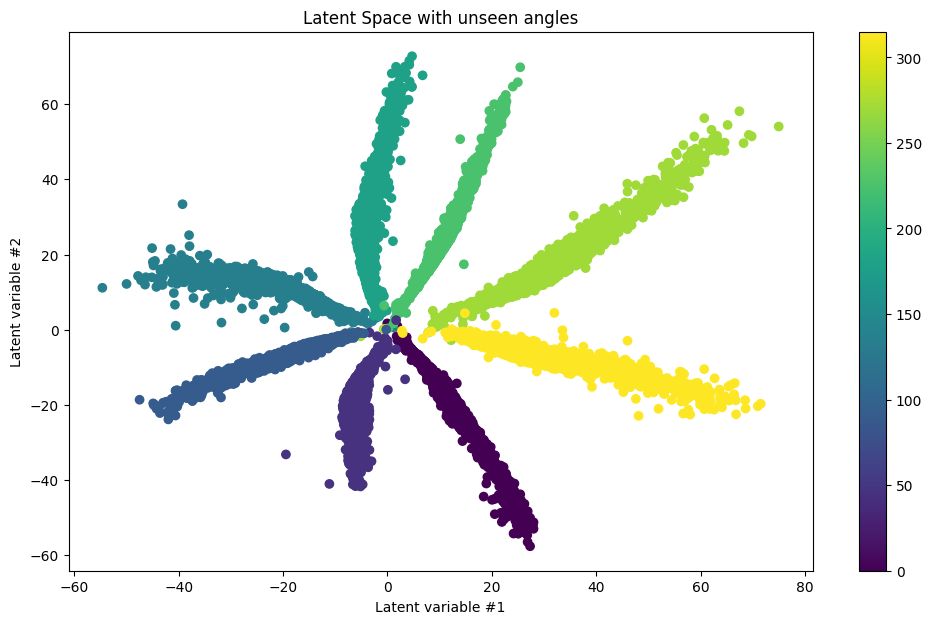

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

autoencoder = Autoencoder(2, 0.2)
autoencoder.load_state_dict(torch.load("../models/autoencoders/autoencoder_dbloss/model_final.pth"))
autoencoder.eval()

raw = pd.read_csv("../data/eight_angles_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()

weights = torch.tensor(weights).float()
latent = autoencoder.encoder(weights).detach().numpy()

print(latent.shape)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot()
img = ax.scatter(latent[:, 0], latent[:, 1], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')


plt.title("Latent Space with unseen angles")
plt.xlabel("Latent variable #1")
plt.ylabel("Latent variable #2")
plt.show()

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Hyperparameters
epochs = 200
lr = 1e-3
batch_size = 100
hidden_dim = 1024


# Dataset
dataset = ModelLatentDataset(latent, angles)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model
flow = Flow(128)
flow.to(device)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)

# Gaussian prior
prior_dim = 2
prior_sd = 1
gaussian = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(prior_dim), math.sqrt(prior_sd) * torch.eye(prior_dim))

path = "../models/generators/"
model_path = path + "flow_conditional_latent.pth"


In [34]:
losses = []
for epoch in tqdm(range(epochs)):    
    for X, y in dataloader:
        optimizer.zero_grad()
        x0 = gaussian.sample((batch_size,)).to(device)
        x1 = X.to(device)

        t = torch.rand(x0.shape[0]).type_as(x0).to(device)

        y = y * torch.pi / 180
        sin = torch.sin(y).to(device)
        cos = torch.cos(y).to(device)

        xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
        ut = compute_conditional_vector_field(x0, x1)        

        vt = flow(torch.cat([xt, t[:, None], sin[:, None], cos[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)

        loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")
        losses.append(loss.item())


torch.save(flow.state_dict(), model_path)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0: Loss 16.75592803955078
Epoch 5: Loss 4.569118022918701
Epoch 10: Loss 4.052161693572998
Epoch 15: Loss 8.041543006896973
Epoch 20: Loss 3.7538390159606934
Epoch 25: Loss 5.199702262878418
Epoch 30: Loss 10.834996223449707
Epoch 35: Loss 4.493882179260254
Epoch 40: Loss 3.382056713104248
Epoch 45: Loss 3.39324951171875
Epoch 50: Loss 3.1041460037231445
Epoch 55: Loss 6.91487979888916
Epoch 60: Loss 9.234540939331055
Epoch 65: Loss 4.52899169921875
Epoch 70: Loss 5.14518404006958
Epoch 75: Loss 4.978295803070068
Epoch 80: Loss 5.833168029785156
Epoch 85: Loss 17.506948471069336
Epoch 90: Loss 4.461830139160156
Epoch 95: Loss 4.455705165863037
Epoch 100: Loss 7.513103485107422
Epoch 105: Loss 6.675233840942383
Epoch 110: Loss 4.338333606719971
Epoch 115: Loss 5.85767126083374
Epoch 120: Loss 5.12921142578125
Epoch 125: Loss 5.256922721862793
Epoch 130: Loss 5.008796215057373
Epoch 135: Loss 4.121720314025879
Epoch 140: Loss 10.028621673583984
Epoch 145: Loss 4.154957294464111
Epo

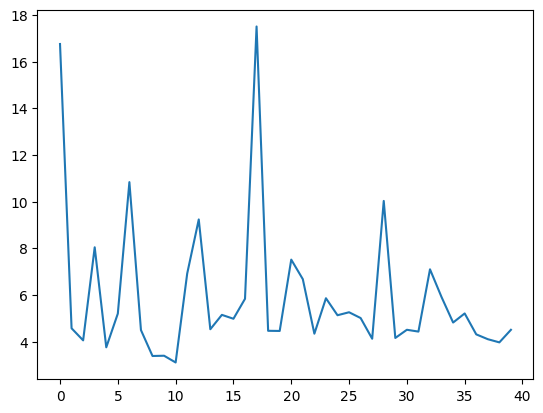

In [35]:
plt.plot(losses)

## Conditional Generation

In [106]:
def generate(model, angle, num_iter=100):
    x = gaussian.sample((1000,))
    angle = torch.tensor([angle*torch.pi/180]).repeat(1000)
    for i in np.linspace(0, 1, num_iter, endpoint=False):
        t = torch.tensor([i], dtype=torch.float32).repeat(1000)
        sin = torch.sin(angle)
        cos = torch.cos(angle)
        path = model(torch.cat([x, t[:, None], sin[:, None], cos[:, None]], dim=-1))
        x += (0.01 * path)
    return x.detach()

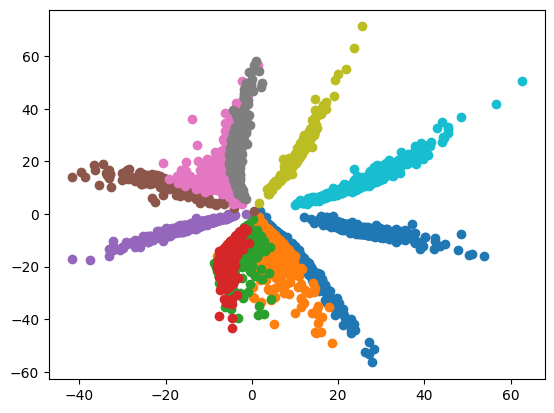

In [148]:
flow = Flow(128)
flow.load_state_dict(torch.load(model_path))
flow.eval()

autoencoder = Autoencoder(2, 0.2)
autoencoder.load_state_dict(torch.load("../models/autoencoders/autoencoder_dbloss/model_final.pth"))
autoencoder.eval()

angles = [0, 22, 36, 45, 90, 135, 160, 180, 225, 270, 315]

for angle in angles:
    x = generate(flow, angle, num_iter=100)
    plt.scatter(x[:, 0], x[:, 1], label=f"{angle} degrees")

plt.show()

In [ ]:
flow = Flow(128)
flow.load_state_dict(torch.load(model_path))
flow.eval()

autoencoder = Autoencoder(2, 0.2)
autoencoder.load_state_dict(torch.load("../models/autoencoders/autoencoder_dbloss/model_final.pth"))
autoencoder.eval()

def slider(angle):
    x = generate(flow, angle, num_iter=100)
    weights = autoencoder.decoder(x[0].unsqueeze(0)).detach().squeeze()
    X, y = get_moons_dataset()
    X_rotated = rotate(X, angle)
    X_rotated = torch.tensor(X_rotated).float()
    plot_decision_boundary(weights, X_rotated, y)

from ipywidgets import interact
interact(slider, angle=(0, 360, 1))

interactive(children=(IntSlider(value=180, description='angle', max=360), Output()), _dom_classes=('widget-int…

<function __main__.slider(angle)>

In [108]:
flow = Flow(128)
flow.load_state_dict(torch.load(model_path))
flow.eval()

autoencoder = Autoencoder(2, 0.2)
autoencoder.load_state_dict(torch.load("../models/autoencoders/autoencoder_dbloss/model_final.pth"))
autoencoder.eval()

accuracies = []
angles = [0, 45, 90, 135, 180, 225, 270, 315]

with torch.no_grad():
    for angle in tqdm(angles):
        x = generate(flow, angle, num_iter=100)
        
        for i in tqdm(range(1000)):
            weights = autoencoder.decoder(x[0].unsqueeze(0)).detach().squeeze()
            X, y = get_moons_dataset()
            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated).float()
            accuracy = get_accuracy(weights, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Mean accuracy: 99.9


In [109]:
flow = Flow(128)
flow.load_state_dict(torch.load(model_path))
flow.eval()

autoencoder = Autoencoder(2, 0.2)
autoencoder.load_state_dict(torch.load("../models/autoencoders/autoencoder_dbloss/model_final.pth"))
autoencoder.eval()

accuracies = []
angles = [45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]

with torch.no_grad():
    for angle in tqdm(angles):
        x = generate(flow, angle, num_iter=100)
        
        for i in tqdm(range(1000)):
            weights = autoencoder.decoder(x[0].unsqueeze(0)).detach().squeeze()
            X, y = get_moons_dataset()
            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated).float()
            accuracy = get_accuracy(weights, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Mean accuracy: 96.975
